# Pre-proj: check bias versus trends in multimodel ensemble
## Plot
conda env: `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period_past = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'tas'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period_past, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, obs.time.size)

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)
obs_regrid.attrs['long_name'] = 'Air Temperature'
obs_regrid.attrs['units'] = units

Reuse existing file: bilinear_70x120_35x60.nc


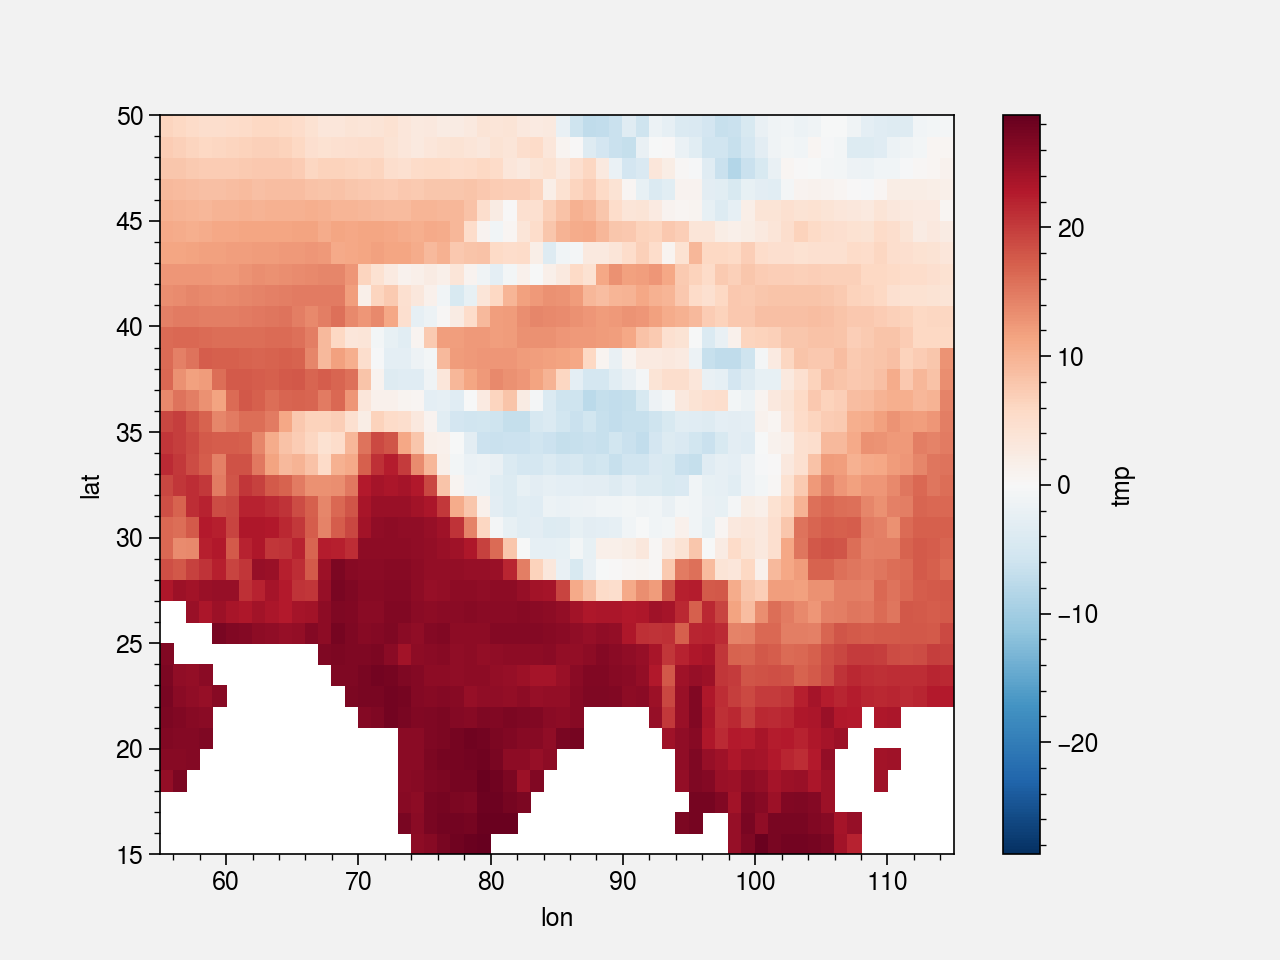

In [9]:
obs_regrid.mean('time').plot()

In [6]:
# obs_regrid

## Load models

In [7]:
list_models = u.get_model_names()
# list_models = list_models[:10]
list_models

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

In [8]:
list_da = []

for model in list_models:
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    path = '/data/mlalande/CMIP6_HMA_paper'
    da = xr.open_dataarray(path+'/'+var+'/'+var+'_'+table+'_'+model+'_historical_ens_'+grid+'_197901-201412_HMA.nc')       
    
    list_da.append(da)

In [11]:
list_da[0]

<xarray.DataArray 'tas' (realization: 3, time: 432, lat: 25, lon: 50)>
[1620000 values with dtype=float64]
Coordinates:
  * time         (time) object 1979-01-16 12:00:00 ... 2014-12-16 12:00:00
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * lon          (lon) float32 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * lat          (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
Attributes:
    regrid_method:  bilinear

## Compute trends

In [12]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [13]:
# obs
ym_temp = []
for season in seasons:
    # Make annual mean
    ym = u.year_mean(obs_regrid, calendar='standard', season=season)

    # Compute trends
    for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
        ym[arr_name] = arr

    ym_temp.append(ym)

ym_obs = xr.concat(ym_temp, pd.Index(seasons, name='season'))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [14]:
%%time

# model
ym_list = []
ens_list = []

for i, model in enumerate(list_models):
    print(model)
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    
    ym_temp = []
    ens_temp = []
    for season in seasons:
        # Make annual mean
        ym = u.year_mean(list_da[i], calendar=calendar, season=season)
        ens = ym.mean('realization')
        
        # Compute trends
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym.year, ym, 'year')):
            ym[arr_name] = arr
            
        for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ens.year, ens, 'year')):
            ens[arr_name] = arr
        
        ym_temp.append(ym)
        ens_temp.append(ens)
        
    concat = xr.concat(ym_temp, pd.Index(seasons, name='season'))
    concat_ens = xr.concat(ens_temp, pd.Index(seasons, name='season'))
    
    ym_list.append(concat)
    ens_list.append(concat_ens)

BCC-CSM2-MR
BCC-ESM1
CAS-ESM2-0
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
CNRM-CM6-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CNRM-CM6-1-HR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CNRM-ESM2-1


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CanESM5
CanESM5-CanOE
GFDL-CM4
GISS-E2-1-G
GISS-E2-1-H
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IPSL-CM6A-LR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


MIROC-ES2L


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


MIROC6


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


MPI-ESM1-2-HR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


MPI-ESM1-2-LR


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


MRI-ESM2-0


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


NorESM2-LM
SAM0-UNICON
TaiESM1
UKESM1-0-LL
CPU times: user 12min 46s, sys: 5.64 s, total: 12min 52s
Wall time: 16min 7s


In [15]:
# ym_list[0]
# ens_list[1]

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2684: UserWarning: Warning: converting a masked element to nan.
  vmin = float(data.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2686: UserWarning: Warning: converting a masked element to nan.
  vmax = float(data.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2684: UserWarning: Warning: converting a masked element to nan.
  vmin = float(data.min())
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/proplot/axes/plot.py:2686: UserWarning

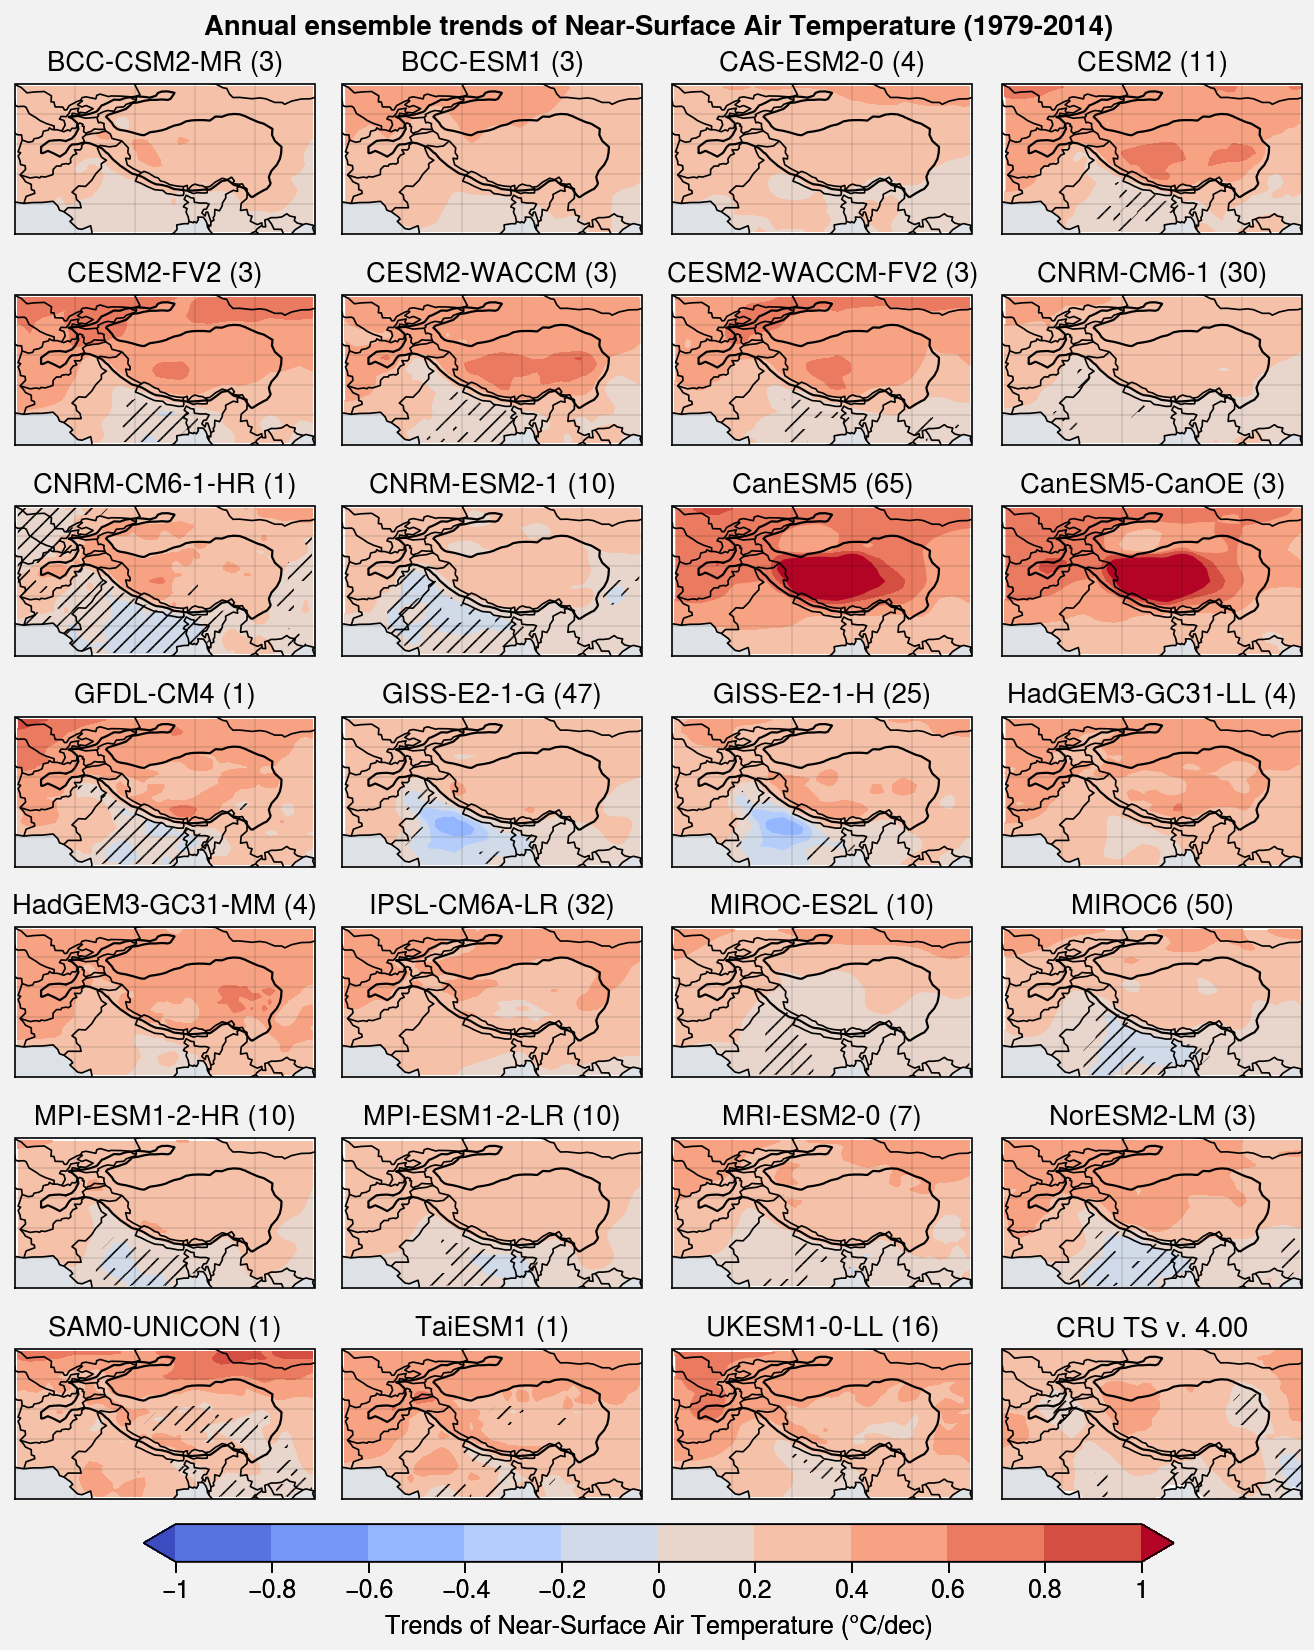

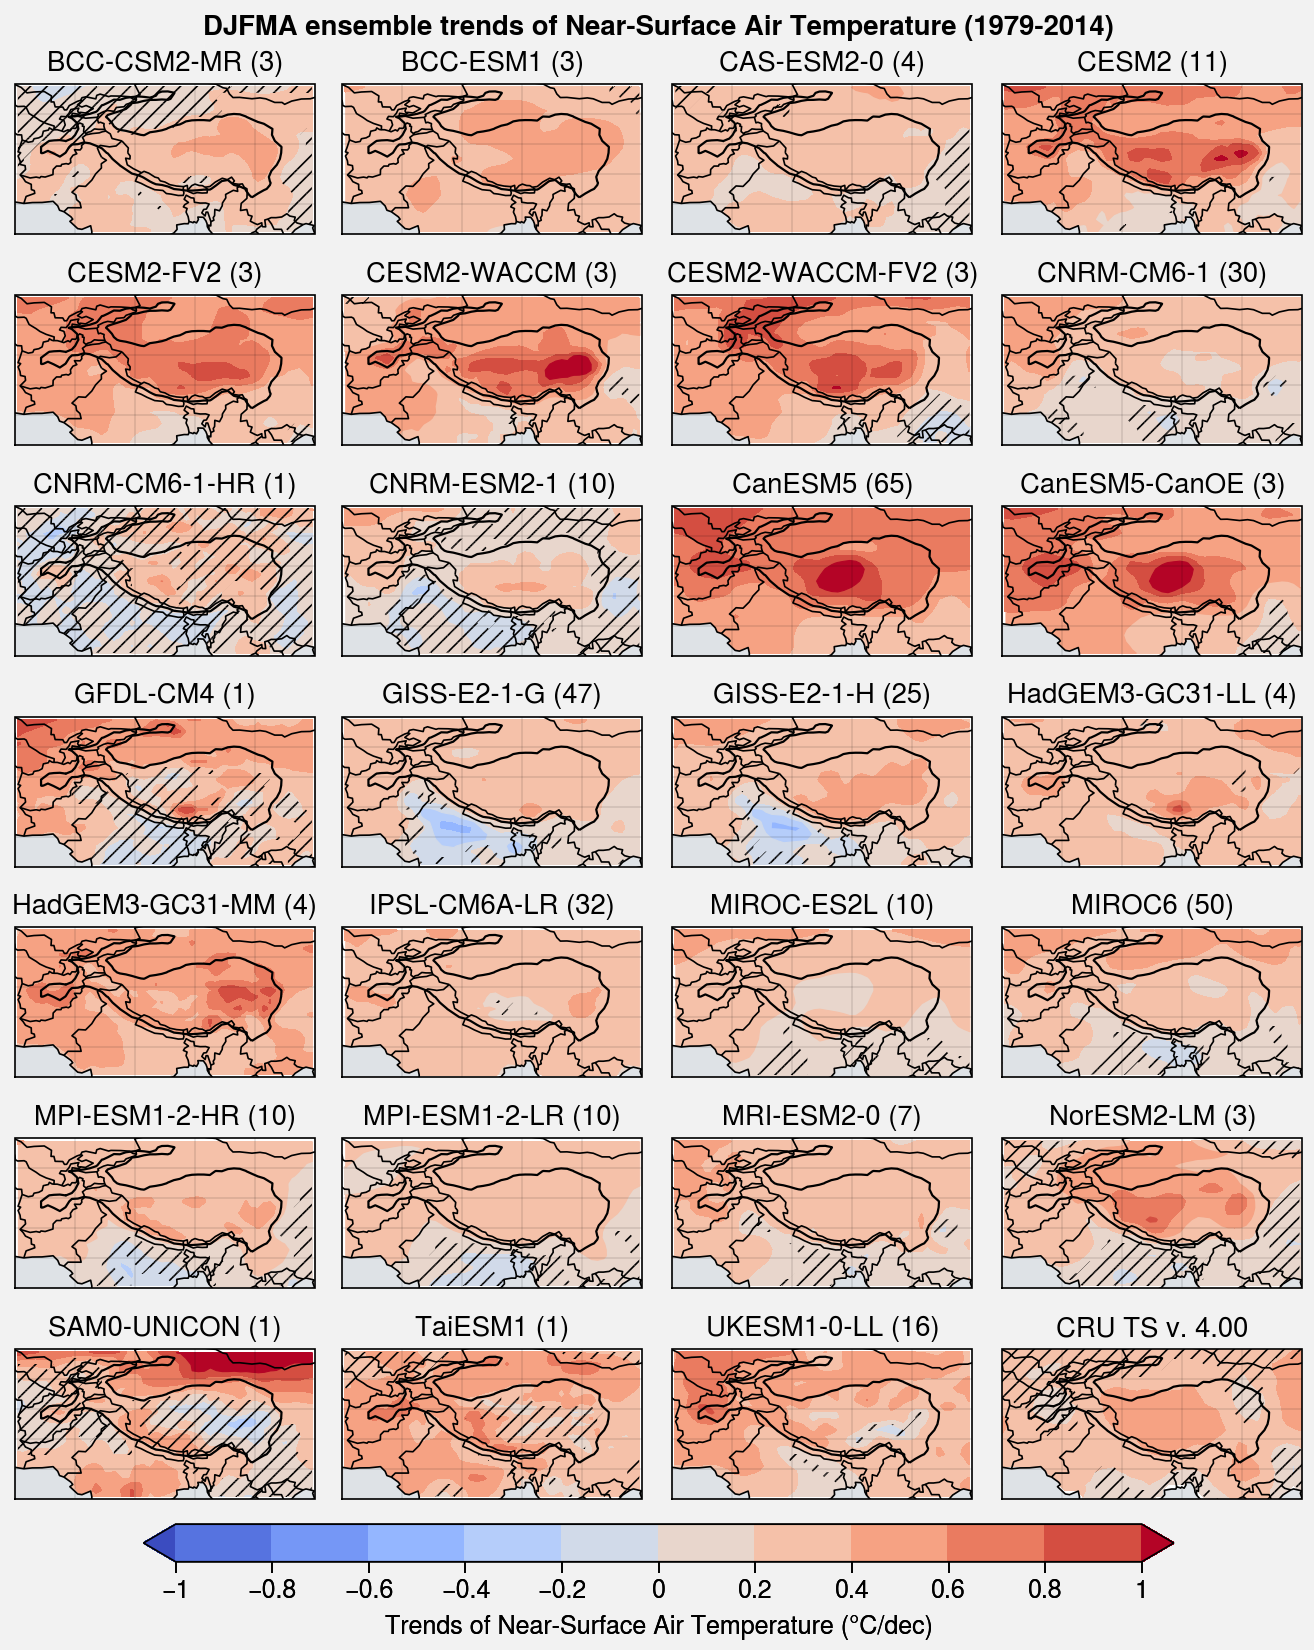

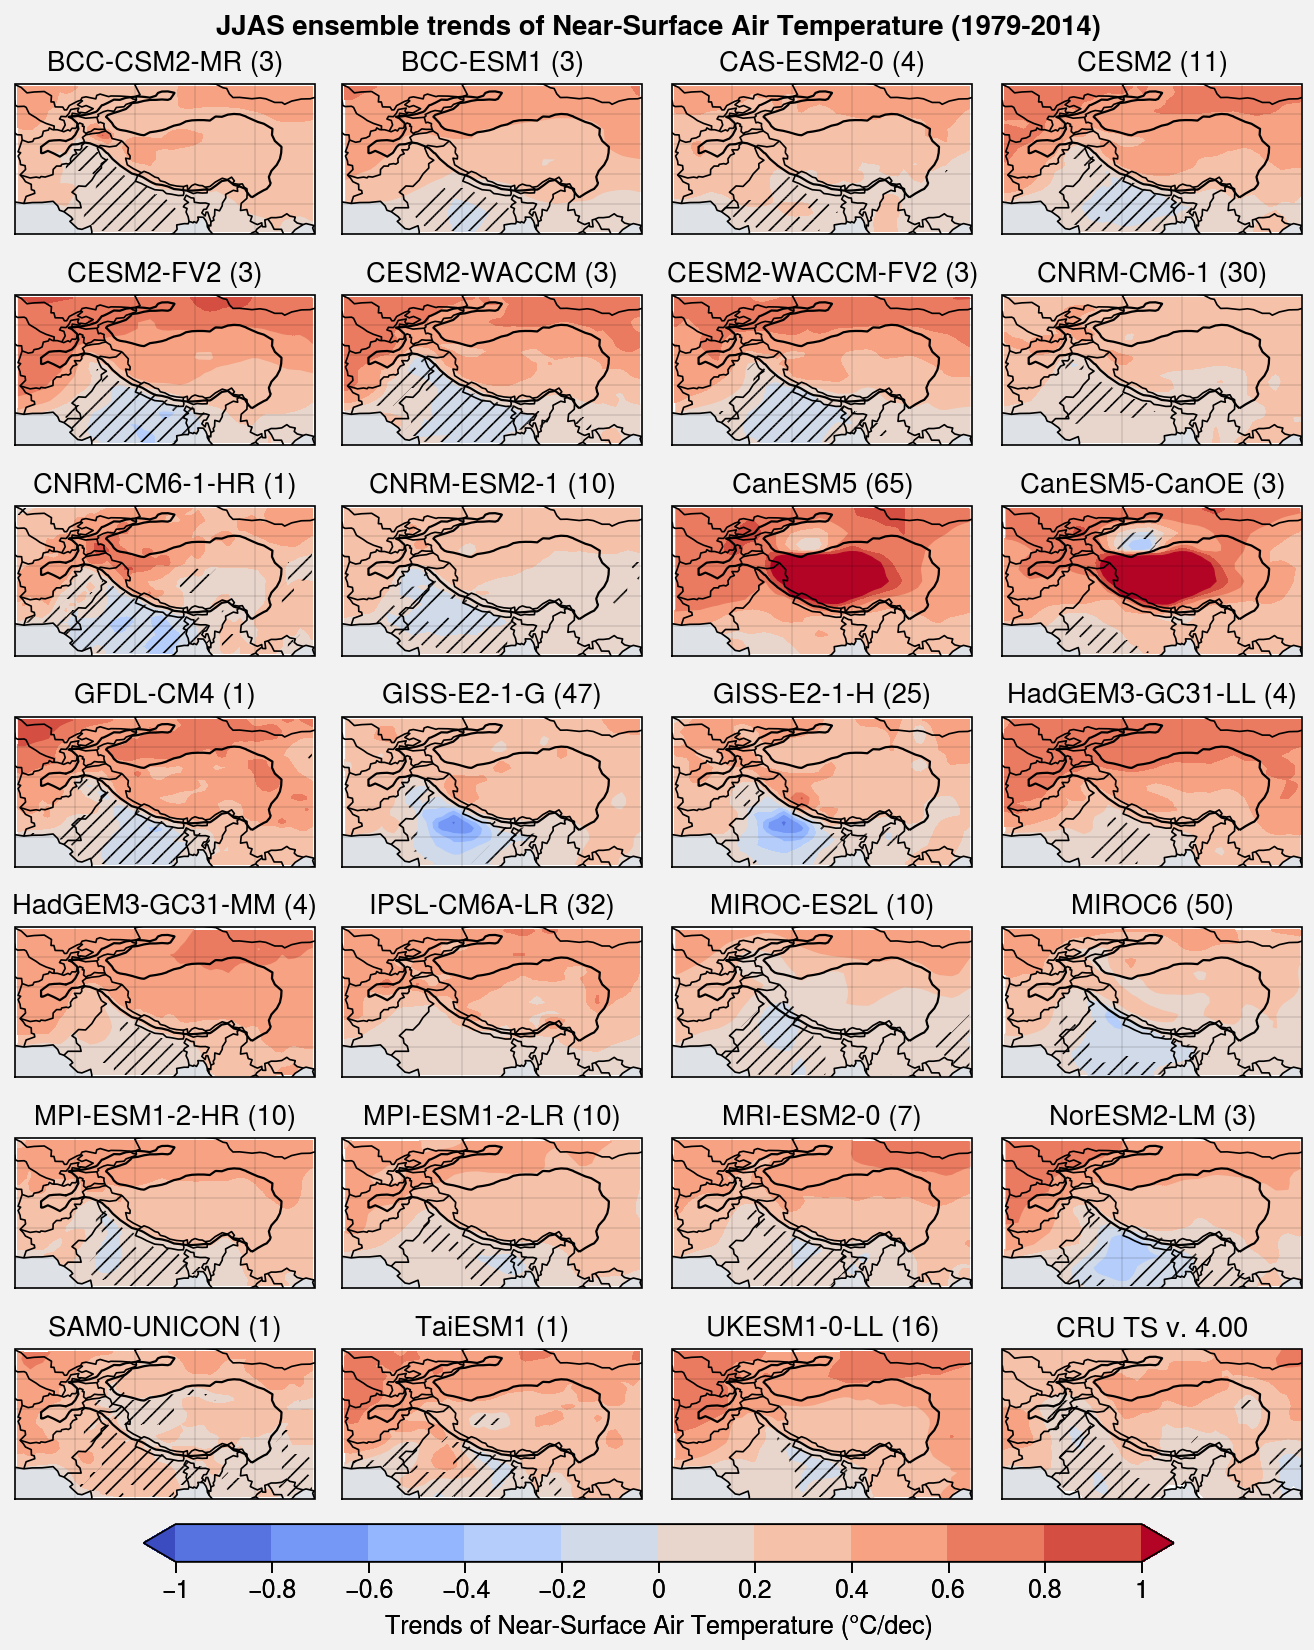

In [17]:
cmap = 'CoolWarm'
levels = plot.arange(-1,1,0.2)
extend = 'both'

for season in seasons:
# for season in ['Annual']:
    f, axs = plot.subplots(proj='cyl', ncols=4, nrows=7, axwidth=1.5)
    
    # Plot observation
    last = len(axs)-1
    axs[last].contour(elevation, levels=[2500], color='black', linewidth=0.8)
    m = axs[last].contourf(
        ym_obs.sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
    )
    pvalue = ym_obs.sel(season=season).pvalue
    axs[last].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)
    axs[last].format(title=obs_longname)
    
    for i, model in enumerate(list_models):
        # Add contour 2500 m
        axs[i].contour(elevation, levels=[2500], color='black', linewidth=0.8)

        # Plot model bias
        m = axs[i].contourf(
            ens_list[i].sel(season=season).slope*10, cmap=cmap, levels=levels, extend=extend
        )
        
        # pvalue
        pvalue = ens_list[i].sel(season=season).pvalue
        axs[i].contourf(pvalue.where(pvalue>0.05), hatches=['////'], alpha=0)

        # Text
        axs[i].format(title=model+' ('+str(ym_list[i].realization.size)+')')

    f.colorbar(m, label='Trends of '+label+' ('+units+'/dec)', loc='b', length=0.8)

    axs.format(
        # Grids, labels and limits
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        
        # Add coast, ocean, borders
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        
        # Suptitle
        suptitle=season+' ensemble trends of '+label+' ('+period_past.start+'-'+period_past.stop+')'   
    )
    
    filename = season+'_trends_'+var+'_'+period_past.start+'-'+period_past.stop
#     f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')